<a href="https://colab.research.google.com/github/Rizkifadillah/latihan_supervised_learning/blob/main/05%20-%20Regression%20Evaluation/Part_9_ElasticNet_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install luwiji

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# *Import Data*

In [3]:
df_path = '/content/drive/MyDrive/course_ipynb/Kumpulan_dataset/taxi_fare.csv'
df = pd.read_csv(df_path, parse_dates=["pickup_datetime"])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [4]:
pickup_dt = df.pickup_datetime.dt
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.dayofweek
df['hour'] = pickup_dt.hour
df.drop(columns="pickup_datetime", inplace=True)
df.head()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


In [5]:
df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude'], inplace=True)
df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# *Dataset Splitting*

In [6]:
X = df.drop(columns="fare_amount") 
y = df.fare_amount 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((15135, 6), (3784, 6), (15135,), (3784,))

# *Training*

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [9]:
preprocessor = ColumnTransformer([
    ("numeric", num_pipe(poly=2, transform='yeo-johnson'), ["passenger_count","year","distance"]),
    ("categoric", cat_pipe(encoder='onehot'), ["month", "day","hour"])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])


model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=3,n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'algo__alpha': 0.0005397956855996446, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.8331949117361646, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7118025163495116 0.7084607864285065 0.7254208882424824


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+05, tolerance: 1.405e+02
  model = cd_fast.enet_coordinate_descent(


# *Feature Importance*

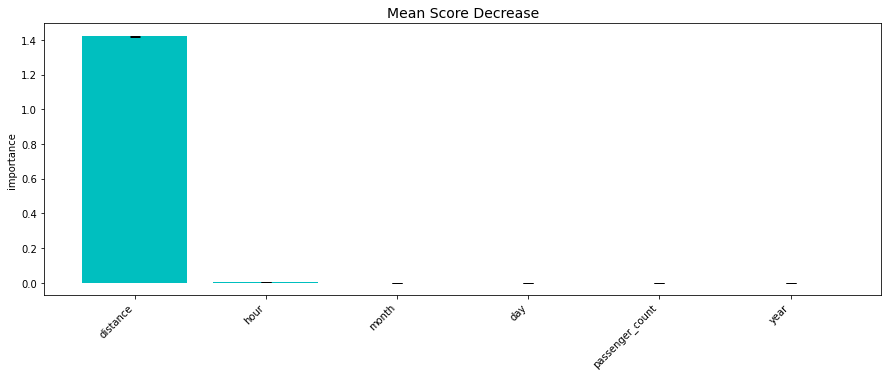

In [10]:
df_imp = mean_score_decrease(X_train,y_train, model, plot=True, topk=10)

# *Evaluation*

In [11]:
from jcopml.plot import plot_residual

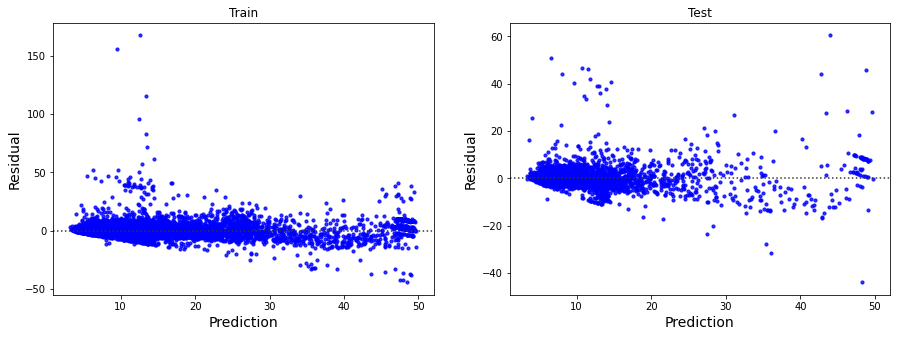

In [12]:
plot_residual(X_train, y_train, X_test, y_test, model)

***Masih aja ada unbalance***

In [14]:
df_analysis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['fare'] = y_train
df_analysis['error'] = error
df_analysis.sort_values("error", ascending=False).head(10)

,passenger_count,year,month,day,hour,distance,fare,error
1335,1.0,2013,1,2,20,0.000000,180.00,167.389280
1483,1.0,2009,8,4,21,0.000416,165.00,155.457531
6630,1.0,2014,5,4,1,0.000000,128.83,115.382722
14142,1.0,2014,12,4,10,0.045860,108.00,95.577850
12915,1.0,2011,9,2,1,0.000000,96.00,82.540532
18150,1.0,2011,12,3,22,0.000000,85.00,71.517177
10524,1.0,2010,5,1,14,0.000000,75.80,61.353394
1494,1.0,2009,9,1,14,0.000031,70.00,57.129596
2432,1.0,2012,11,4,1,0.003817,58.60,52.373569
18807,2.0,2013,8,5,2,0.038527,61.25,51.576841
